#Librerias y Verificaciones

In [1]:
!pip install -q mediapy
import mediapy as media
import cv2
import numpy as np

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 17.1 MB/s eta 0:00:00


In [2]:
#Esto convierte el video a un formato más liviano de trabajo
!ffmpeg -y -i video_cv.mp4 -vf "scale=600:-1" -an -t 30 video_cv_600.mp4

ffmpeg version 4.4.2-0ubuntu0.22.04.1 Copyright (c) 2000-2021 the FFmpeg developers
  built with gcc 11 (Ubuntu 11.2.0-19ubuntu1)
  configuration: --prefix=/usr --extra-version=0ubuntu0.22.04.1 --toolchain=hardened --libdir=/usr/lib/x86_64-linux-gnu --incdir=/usr/include/x86_64-linux-gnu --arch=amd64 --enable-gpl --disable-stripping --enable-gnutls --enable-ladspa --enable-libaom --enable-libass --enable-libbluray --enable-libbs2b --enable-libcaca --enable-libcdio --enable-libcodec2 --enable-libdav1d --enable-libflite --enable-libfontconfig --enable-libfreetype --enable-libfribidi --enable-libgme --enable-libgsm --enable-libjack --enable-libmp3lame --enable-libmysofa --enable-libopenjpeg --enable-libopenmpt --enable-libopus --enable-libpulse --enable-librabbitmq --enable-librubberband --enable-libshine --enable-libsnappy --enable-libsoxr --enable-libspeex --enable-libsrt --enable-libssh --enable-libtheora --enable-libtwolame --enable-libvidstab --enable-libvorbis --enable-libvpx --enab

In [ ]:
video = media.read_video('video_alejo1.mp4') #verificamos que el video corra correctamente
media.show_video(video)

#Ejercicio 5:
El objetivo de este ejercicio es llevar a cabo la detección de una persona en movimiento en un video grabado en un patio o pasillo de un edificio. Para ello utilizaré métodos de detección de movimiento sin depender del deep learning.

Posteriormente, aplicaré los algoritmos de flujo óptico, tanto densos como dispersos, que fueron presentados durante las clases. Al finalizar, compartiré una reflexión sobre los resultados obtenidos y su relevancia en el contexto de la seguridad y vigilancia.

In [3]:
def process_video(filename_in, filename_out, process_func, max_time=10, **kwargs):

    with media.VideoReader(filename_in) as r:    # abro el video de entrada para lectura

        with media.VideoWriter(filename_out, shape=r.shape, fps=r.fps, bps=r.bps) as w:  # Creo un archivo de video de salida
            count = 0  # contador de fotogramas
            prev_image = None  # imagen previa

            # itero sobre cada imagen (fotograma) del video
            for image in r:

                new_image = media.to_uint8(image)  # convierto la imagen a formato flotante

                if prev_image is None: prev_image = new_image.copy()   # compruebo si es la primera imagen

                processed_image = process_func(new_image, prev_image, **kwargs) # utilizando la función dada, proceso la imagen

                w.add_image(processed_image)   # añado la imagen procesada al video de salida

                prev_image = new_image.copy() # actualizo la imagen previa

                count += 1  # incremento el contador de fotogramas

                if count >= max_time * r.fps:   # cuando se alcance el tiempo máximo, detengo el proceso
                    break

def draw_contours(frame, contours, color=(0, 255, 0), thickness=2):

    # si la imagen está en escala de grises --> la convierto a color. Si no, hago una copia
    if len(frame.shape) == 2 or frame.shape[2] == 1: result_image = cv2.cvtColor(frame, cv2.COLOR_GRAY2BGR)
    else: result_image = frame.copy()

    # para cada contorno encontrado, dibujo su bounding box
    for contour in contours:
      if cv2.contourArea(contour) > 15000:
        x, y, w, h = cv2.boundingRect(contour)
        cv2.rectangle(result_image, (x, y), (x + w, y + h), color, thickness)
    return result_image

def frame_difference(new_image, prev_image, **kwargs):

    # convierto el frame anterior y el actual a escala de grises
    new_gray = cv2.cvtColor(new_image, cv2.COLOR_RGB2GRAY)
    prev_gray = cv2.cvtColor(prev_image, cv2.COLOR_RGB2GRAY)

    frame_diff = cv2.absdiff(new_gray, prev_gray)  # calculo diferencia absoluta entre ambos fotogramas

    norm_diff = cv2.normalize(frame_diff, None, 0, 255, cv2.NORM_MINMAX)  # normalizo la imagen de diferencia

    _, thresh = cv2.threshold(norm_diff, 30, 255, cv2.THRESH_BINARY)  # umbralizo la imagen de diferencia

    kernel = np.ones((5,5),np.uint8)
    dilated = cv2.dilate(thresh, kernel, iterations = 1)     # dilato la imagen umbralizada con un kernel de 5x5

    dilated = dilated.astype(np.uint8)   # convierto la imagen dilatada a formato adecuado para findContours

    contours, _ = cv2.findContours(dilated, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)   # encuentro contornos en la imagen dilatada

    if kwargs.get('draw_mode', 0) == 0:
      result_image = draw_contours(new_image, contours)   # si draw_mode = 0 --> dibujo los bounding boxes sobre la imagen a color
    elif kwargs.get('draw_mode', 0) == 1:
      result_image = draw_contours(thresh, contours)   # si draw_mode = 1 --> dibujo los bounding boxes sobre la iamgen binarizada

    return result_image


In [ ]:
filename_in = 'video_alejo1.mp4'        # video de entrada
filename_out = 'video_alejo_umbralizado.mp4'  # nombre del video de salida

# llamo a la función y muestro el video umbralizado

process_video(filename_in, filename_out, frame_difference,
                max_time=10, draw_mode=1)

media.show_video(media.read_video(filename_out), fps=30)

# llamo a la función y muestro el video a color

filename_out = 'video_alejo_color.mp4'
process_video(filename_in, filename_out, frame_difference,
                max_time=10, draw_mode=0)

media.show_video(media.read_video(filename_out), fps=30)

In [5]:
def scattered_optic(new_image, prev_image):
    # convierto frame actual y anterior a blanco y negro
    new_gray = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
    prev_gray_image = cv2.cvtColor(prev_image, cv2.COLOR_BGR2GRAY)

    # Verifico si ya se han detectado las características de Shi-Tomasi
    if not hasattr(scattered_optic, "shi_tomasi_done"):

        feature_params = dict(maxCorners=300, qualityLevel=0.2, minDistance=2, blockSize=7) # defino parámetros para la detección de esquinas de Shi-Tomasi

        scattered_optic.prev_points = cv2.goodFeaturesToTrack(new_gray, mask=None, **feature_params) # detecto puntos característicos en la imagen

        scattered_optic.mask = np.zeros_like(new_image) # creo una máscara para dibujar el flujo óptico

        scattered_optic.shi_tomasi_done = True   # marco que se ha completado la detección de Shi-Tomasi

    # Continuar si se ha completado la detección de Shi-Tomasi
    if scattered_optic.shi_tomasi_done:
        prev_points = scattered_optic.prev_points
        mask = scattered_optic.mask

    # defino parámetros para el flujo óptico de Lucas-Kanade
    lk_params = dict(winSize=(15, 15), maxLevel=2,
                     criteria=(cv2.TERM_CRITERIA_EPS | cv2.TERM_CRITERIA_COUNT, 10, 0.03))

    # calculo el flujo óptico de Lucas-Kanade
    new_points, status, error = cv2.calcOpticalFlowPyrLK(prev_gray_image, new_gray, prev_points, None, **lk_params)
    # filtro puntos buenos
    good_old = prev_points[status == 1]
    good_new = new_points[status == 1]
    color = (0, 255, 0)  # color para el dibujo
    # dibujo el movimiento (flujo óptico)
    for i, (new, old) in enumerate(zip(good_new, good_old)):
        a, b = new.astype(int).ravel()
        c, d = old.astype(int).ravel()
        mask = cv2.line(mask, (a, b), (c, d), color, 2)
        new_image = cv2.circle(new_image, (a, b), 3, color, -1)


    output = cv2.add(new_image, mask) # combino la imagen actual con las líneas de flujo óptico dibujadas

    scattered_optic.prev_points = good_new.reshape(-1, 1, 2) # actualizo puntos para el siguiente cuadro
    return output

In [ ]:
filename_in = 'video_alejo1.mp4'   # video de entrada
filename_out = 'video_alejo_scattered.mp4' # nombre video de salida

# llamo a la función para procesar el video y muestro el resultado
process_video(filename_in, filename_out, scattered_optic, max_time=10)

media.show_video(media.read_video(filename_out), fps=30)

In [7]:
def optical_denso(new_image, prev_image):

    gray = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY) # convierto imagen a grises

    if not hasattr(optical_denso, "init_done"):
        optical_denso.prev_gray = cv2.cvtColor(new_image, cv2.COLOR_BGR2GRAY)
        optical_denso.mask = np.zeros_like(new_image)
        optical_denso.mask[..., 1] = 255
        optical_denso.init_done = True

    if optical_denso.init_done:
        prev_gray = optical_denso.prev_gray
        mask = optical_denso.mask

    flow = cv2.calcOpticalFlowFarneback(prev_gray, gray, None, 0.5, 3, 15, 3, 5, 1.2, 0)  # calcula flujo óptico

    magnitude, angle = cv2.cartToPolar(flow[..., 0], flow[..., 1])  # magnitud y ángulo de los vectores

    mask[..., 0] = angle * 180 / np.pi / 2  # tono de la imagen según la dirección del flujo óptico

    mask[..., 2] = cv2.normalize(magnitude, None, 0, 255, cv2.NORM_MINMAX)   # valor de la imagen según la magnitud del flujo óptico

    rgb = cv2.cvtColor(mask, cv2.COLOR_HSV2BGR)   # convierto de HSV a RGB

    optical_denso.prev_grayprev_gray = gray.copy()  # actualizo imagen previa a gris

    return rgb

In [ ]:
# llamo a la función y muestro el resultado

process_video('video_alejo1.mp4', 'video_alejo_denso.mp4', optical_denso,
                max_time=20)

media.show_video(media.read_video('video_alejo_denso.mp4'), fps=30)

##Reflecciones:
Después de aplicar los tres métodos de detección de movimiento al video grabado en el living de mi casa, voy a compartir mis observaciones finales.

En primer lugar, el algoritmo que se basa en la diferencia entre los fotogramas revela cierta inestabilidad. Aunque logra identificar correctamente el movimiento de la persona, también genera una cantidad considerable de ruido, evidenciada por la aparición de numerosos bounding boxes adicionales. Además, este método tiende a detectar la sombra de la persona, lo cual no es relevante en este contexto. Por eso decidi agregar un condicial para que solo recuadre un tamaño especifico de area.

Por otro lado, el algoritmo de flujo óptico disperso ofrece resultados más prometedores. En este caso, se observan menos errores y se detecta el movimiento de la persona de manera más precisa.

Por último, el algoritmo de flujo óptico denso presenta algunas limitaciones, como la detección de partes del fondo como si estuvieran en movimiento, lo cual es incorrecto. Sin embargo, cuando la persona está presente en la escena, este método sigue correctamente su movimiento.

En cuanto a los tiempos de procesamiento, es evidente que el algoritmo de flujo óptico denso consume más recursos, ya que calcula el flujo para cada píxel en cada fotograma.

En resumen, para este video en particular, el método de Diferencia de Fotogramas es el más eficaz en la detección de movimiento, ya que produce menos ruido y permite visualizar claramente el movimiento de la persona. Aunque los otros métodos también detectan el movimiento, se ven afectados por el ruido de fondo. Es posible que grabar el video en un entorno con un fondo más uniforme produzca resultados aún mejores.

#Ejercicio 6:
El propósito de este ejercicio es estender la diferencia entre la localización de objetos y la clasificación de imágenes, utilizando ejemplos concretos.

Ambos conceptos son comúnmente confundidos y, aunque son problemas abordados por el procesamiento de imágenes, poseen enfoques diferentes.

La clasificación de imágenes se centra en etiquetar el contenido de una imagen, mientras que la localización de objetos tiene como objetivo identificar y ubicar la posición de los objetos en imágenes o vídeos. Es decir, la localización no se limita a identificar qué hay en la imagen, sino también a determinar dónde se encuentra el objeto de interés.

Un ejemplo frecuente de localización de objetos es el sistema de detección facial en cámaras de teléfonos celulares, que reconoce los rostros de las personas y marca su posición para mejorar la calidad de la imagen. Otro ejemplo es el uso de algoritmos de localización de objetos en sistemas de conducción autónoma, donde se identifican y clasifican elementos del entorno, como peatones y señales de tráfico, para tomar decisiones de manejo adecuadas.

En términos de funcionamiento, la localización de objetos se basa en algoritmos y técnicas que permiten detectar características distintivas de los objetos, como sus contornos, texturas o colores.

A continuación se presenta una imagen de ejemplo donde se localizan distintos objetos. Además de identificarlos mediante un cuadro delimitador, se proporciona información sobre qué objeto se está mostrando.








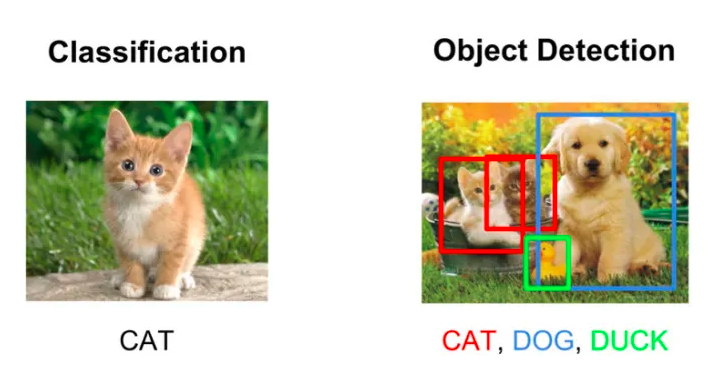

Además, la clasificación de imágenes se enfoca en analizar una imagen dada y asignarle una etiqueta que la clasifique dentro de un conjunto predefinido de categorías posibles.

Estos algoritmos encuentran aplicación en diversos campos, como el reconocimiento facial o el diagnóstico médico.

A continuacion, se muestra una imagen como ejemplo. Utilizando un algoritmo de detección de objetos llamado YOLO, pudimos verificar que la imagen contiene un perro, una bicicleta y un auto.

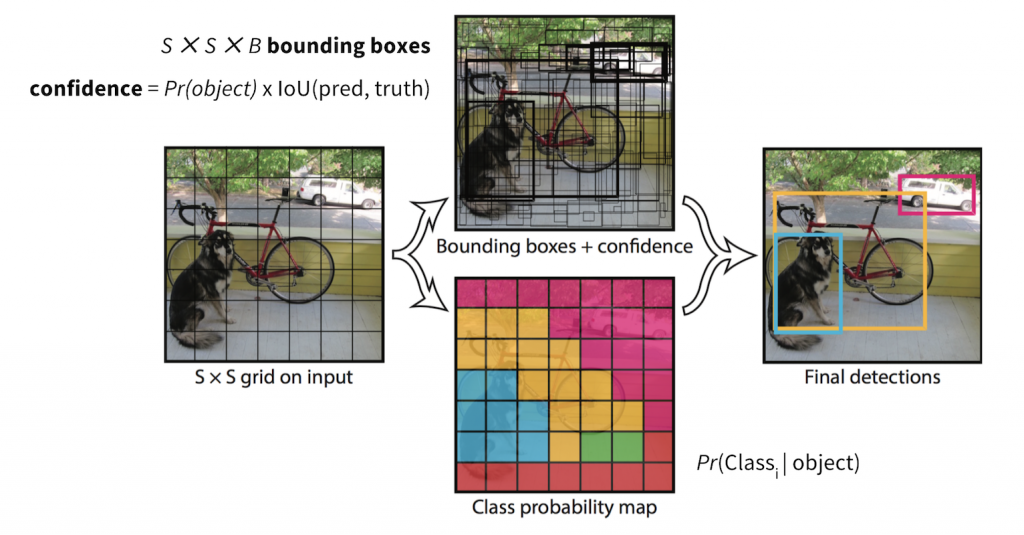

Para finalizar, la clasificación de imágenes y la localización de objetos representan dos enfoques distintos en el procesamiento de imágenes, cada uno con sus propias aplicaciones y métodos particulares. Mientras que la clasificación de imágenes etiqueta imágenes completas, la localización de objetos se centra en identificar la presencia y la posición de objetos específicos dentro de la misma.